This notebook is a tutorial for training and prediction in data2.

# Load Dependencies

In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import numpy as np
import pandas as pd
import glob
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Multiply,LSTM
from script.utils import SPMS
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import numpy as np
import tensorflow as tf
from script.MIGNN_model import Graph_DataLoader,MIGNN_model2
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

Using backend: pytorch[10:26:02] /opt/dgl/src/runtime/tensordispatch.cc:43: TensorDispatcher: dlopen failed: /root/anaconda3/lib/python3.8/site-packages/dgl/tensoradapter/pytorch/libtensoradapter_pytorch_1.11.0.so: cannot open shared object file: No such file or directory



# Load Steric and Electronic Information

In [2]:
react_spms = np.load('./data2/run_data/data2_SEMG_MIGNN_react_spms.npy')
react_elec = np.load('./data2/run_data/data2_SEMG_MIGNN_react_elec.npy')
labels = np.load('./data2/run_data/data2_SEMG_MIGNN_labels.npy')
label_std = np.load('./data2/run_data/data2_SEMG_MIGNN_label_std.npy')

# IGNN model

In [13]:
cat_size=184
imine_size=33
thiol_size=19
hidden_size=256
linear_depth=6
atom_attention=1
inter_attention=1
end_attention=1
inter_len=8
spms_number=32
ele_number=32
fc_size=256
final_act='sigmoid'

In [14]:
hidden_size

256

In [15]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Multiply,LSTM


cat_size = cat_size
imine_size = imine_size
thiol_size = thiol_size
hidden_size = hidden_size
linear_depth = linear_depth
atom_attention=atom_attention
inter_attention=inter_attention
end_attention=end_attention
inter_len=inter_len
#interaction=interaction
final_act = final_act
spms_number=spms_number
ele_number=ele_number

norm_cat = keras.layers.BatchNormalization()
norm_imine = keras.layers.BatchNormalization()
norm_thiol = keras.layers.BatchNormalization()
norm_ar_ha = keras.layers.BatchNormalization()    
cat_spms_init_layer = keras.layers.Dense(hidden_size,
                           kernel_initializer=tf.random_normal_initializer(stddev=0.1),use_bias=False)
cat_spms_hidden_layer = keras.layers.Dense(hidden_size,
                             kernel_initializer=tf.random_normal_initializer(stddev=0.1),use_bias=False)
cat_spms_final_layer = keras.layers.Dense(1,
                            kernel_initializer=tf.random_normal_initializer(stddev=0.1),use_bias=False)
cat_spms_attention_dense = Dense(cat_size, activation='softmax', name='attention_vec')
cat_spms_attention_mul =  Multiply()
cat_elec_init_layer = keras.layers.Dense(hidden_size,
                           kernel_initializer=tf.random_normal_initializer(stddev=0.1),use_bias=False)
cat_elec_hidden_layer = keras.layers.Dense(hidden_size,
                             kernel_initializer=tf.random_normal_initializer(stddev=0.1),use_bias=False)
cat_elec_final_layer = keras.layers.Dense(1,
                            kernel_initializer=tf.random_normal_initializer(stddev=0.1),use_bias=False)       
cat_elec_attention_dense = Dense(cat_size, activation='softmax', name='attention_vec')
cat_elec_attention_mul =  Multiply()        
imine_spms_init_layer = keras.layers.Dense(hidden_size,
                           kernel_initializer=tf.random_normal_initializer(stddev=0.1),use_bias=False)
imine_spms_hidden_layer = keras.layers.Dense(hidden_size,
                             kernel_initializer=tf.random_normal_initializer(stddev=0.1),use_bias=False)
imine_spms_final_layer = keras.layers.Dense(1,
                            kernel_initializer=tf.random_normal_initializer(stddev=0.1),use_bias=False)
imine_spms_attention_dense = Dense(imine_size, activation='softmax', name='attention_vec')
imine_spms_attention_mul =  Multiply()

imine_elec_init_layer = keras.layers.Dense(hidden_size,
                           kernel_initializer=tf.random_normal_initializer(stddev=0.1),use_bias=False)
imine_elec_hidden_layer = keras.layers.Dense(hidden_size,
                             kernel_initializer=tf.random_normal_initializer(stddev=0.1),use_bias=False)
imine_elec_final_layer = keras.layers.Dense(1,
                            kernel_initializer=tf.random_normal_initializer(stddev=0.1),use_bias=False)
imine_elec_attention_dense = Dense(imine_size, activation='softmax', name='attention_vec')
imine_elec_attention_mul =  Multiply()  
thiol_spms_init_layer = keras.layers.Dense(hidden_size,
                             kernel_initializer=tf.random_normal_initializer(stddev=0.1),use_bias=False)
thiol_spms_hidden_layer = keras.layers.Dense(hidden_size,
                               kernel_initializer=tf.random_normal_initializer(stddev=0.1),use_bias=False)
thiol_spms_final_layer = keras.layers.Dense(1,kernel_initializer=tf.random_normal_initializer(stddev=0.1),use_bias=False)
thiol_spms_attention_dense = Dense(thiol_size, activation='softmax', name='attention_vec')
thiol_spms_attention_mul =  Multiply()        
thiol_elec_init_layer = keras.layers.Dense(hidden_size,
                             kernel_initializer=tf.random_normal_initializer(stddev=0.1),use_bias=False)
thiol_elec_hidden_layer = keras.layers.Dense(hidden_size,
                               kernel_initializer=tf.random_normal_initializer(stddev=0.1),use_bias=False)
thiol_elec_final_layer = keras.layers.Dense(1,kernel_initializer=tf.random_normal_initializer(stddev=0.1),use_bias=False)
thiol_elec_attention_dense = Dense(thiol_size, activation='softmax', name='attention_vec')
thiol_elec_attention_mul =  Multiply()  

super_spms_attention_dense = Dense(spms_number, activation='softmax', name='attention_vec')
super_spms_attention_mul =  Multiply() 
super_ele_attention_dense = Dense(ele_number, activation='softmax', name='attention_vec')
super_ele_attention_mul =  Multiply() 
conv2d_1 = keras.layers.Conv2D(16,(3,5))
conv2d_2 = keras.layers.Conv2D(16,(2,3))
conv2d_3 = keras.layers.Conv2D(1,(16,16))
conv2d_4 = keras.layers.Conv2D(1,(8,8))
conv2d_5 = keras.layers.Conv2D(1,(inter_len,inter_len))
conv2d_6 = keras.layers.Conv2D(1,(16,16))
conv2d_7 = keras.layers.Conv2D(1,(8,8))
conv2d_8 = keras.layers.Conv2D(1,(inter_len,inter_len))
conv3d = keras.layers.Conv3D(16,4)
fc_1 = keras.layers.Dense(fc_size)
fc_2 = keras.layers.Dense(fc_size)
fc_3 = keras.layers.Dense(1,activation='sigmoid')
fc_4 = keras.layers.Dense(1)
fc_5 = keras.layers.Dense(32)
fc_6 = keras.layers.Dense(32)

maxpooling_2d = keras.layers.MaxPool2D(2)
maxpooling_3d = keras.layers.MaxPool3D(2)
flatten = keras.layers.Flatten()        
x_attention_dense = Dense(434, activation='softmax', name='attention_vec')
x_attention_mul =  Multiply()    

In [57]:
spms_x = spms_train
elec_x = elec_train
number_batch=len(spms_x)
cat_x = spms_x[:,:,:,:cat_size]
imine_x = spms_x[:,:,:,cat_size:cat_size+imine_size]
thiol_x = spms_x[:,:,:,cat_size+imine_size:]
cat_elec_x = elec_x[:,:,:,:,:cat_size]
imine_elec_x = elec_x[:,:,:,:,cat_size:cat_size+imine_size]
thiol_elec_x = elec_x[:,:,:,:,cat_size+imine_size:]
for i in range(atom_attention):
    cat_x_=cat_spms_attention_dense(cat_x)
    cat_x=cat_spms_attention_mul([cat_x,cat_x_])    
    imine_x_=imine_spms_attention_dense(imine_x)
    imine_x=imine_spms_attention_mul([imine_x,imine_x_])  
    thiol_x_=thiol_spms_attention_dense(thiol_x)
    thiol_x=thiol_spms_attention_mul([thiol_x,thiol_x_])   
    cat_elec_x_=cat_elec_attention_dense(cat_elec_x)
    cat_elec_x=cat_elec_attention_mul([cat_elec_x,cat_elec_x_])
    imine_elec_x_=imine_elec_attention_dense(imine_elec_x)
    imine_elec_x=imine_elec_attention_mul([imine_elec_x,imine_elec_x_])
    thiol_elec_x_=thiol_elec_attention_dense(thiol_elec_x)
    thiol_elec_x=thiol_elec_attention_mul([thiol_elec_x,thiol_elec_x_])  
#cat_x_=cat_x_
#imine_x_=imine_x_
#thiol_x_=thiol_x_
#thiol_x=thiol_x
cat_x = cat_spms_init_layer(cat_x)
for i in range(linear_depth):
    cat_x = cat_spms_hidden_layer(cat_x)
cat_x = cat_spms_final_layer(cat_x)
cat_x = norm_cat(cat_x)
cat_x = tf.nn.tanh(cat_x)
imine_x = imine_spms_init_layer(imine_x)
for i in range(linear_depth):
    imine_x = imine_spms_hidden_layer(imine_x)
imine_x = imine_spms_final_layer(imine_x)
imine_x = norm_imine(imine_x)
imine_x = tf.nn.tanh(imine_x)
thiol_x = thiol_spms_init_layer(thiol_x)
for i in range(linear_depth):
    thiol_x = thiol_spms_hidden_layer(thiol_x)   
thiol_x = thiol_spms_final_layer(thiol_x)
thiol_x = norm_thiol(thiol_x)
thiol_x = tf.nn.tanh(thiol_x)
react_spms_mat = tf.concat([cat_x,imine_x,thiol_x],axis=3)
react_spms_x = conv2d_2(maxpooling_2d(conv2d_1(react_spms_mat)))
react_spms_x = flatten(react_spms_x)    
cat_elec_x = cat_elec_init_layer(cat_elec_x)
for i in range(linear_depth):
    cat_elec_x = cat_elec_hidden_layer(cat_elec_x)
cat_elec_x = cat_elec_final_layer(cat_elec_x)
cat_elec_x = tf.nn.tanh(cat_elec_x)
imine_elec_x = imine_elec_init_layer(imine_elec_x)
for i in range(linear_depth):
    imine_elec_x = imine_elec_hidden_layer(imine_elec_x)
imine_elec_x = imine_elec_final_layer(imine_elec_x)
imine_elec_x = tf.nn.tanh(imine_elec_x)
thiol_elec_x = thiol_elec_init_layer(thiol_elec_x)
for i in range(linear_depth):
    thiol_elec_x = thiol_elec_hidden_layer(thiol_elec_x)
thiol_elec_x = thiol_elec_final_layer(thiol_elec_x)
thiol_elec_x = tf.nn.tanh(thiol_elec_x)
react_elec_x = tf.concat([cat_elec_x,imine_elec_x,thiol_elec_x],axis=4)
react_elec_x = flatten(maxpooling_3d(conv3d(react_elec_x)))
react_spms_x_=react_spms_x
react_elec_x_=react_elec_x
react_spms_x=fc_5(react_spms_x)
react_elec_x=fc_6(react_elec_x)
super_spms=tf.reshape(react_spms_x,[number_batch,1,spms_number])
super_ele=tf.reshape(react_elec_x,[number_batch,1,ele_number])
for i in range(inter_attention):
    super_spms_=super_spms_attention_dense(super_spms)
    super_spms=super_spms_attention_mul([super_spms,super_spms_])    
    super_ele_=super_ele_attention_dense(super_ele)
    super_ele=super_ele_attention_mul([super_ele,super_ele_])

    
react_spms_x=tf.matmul(tf.reshape(react_spms_x,[number_batch,spms_number,1]),super_spms)
react_spms_x=tf.reshape(react_spms_x,[number_batch,spms_number,spms_number,1])
react_spms_x=flatten(conv2d_5(conv2d_4(conv2d_3(react_spms_x))))#
react_spms_x=tf.reshape(react_spms_x,[number_batch,-1])

react_elec_x=tf.matmul(tf.reshape(react_elec_x,[number_batch,ele_number,1]),super_ele)
react_elec_x=tf.reshape(react_elec_x,[number_batch,ele_number,ele_number,1])
react_elec_x=flatten(conv2d_8(conv2d_7(conv2d_6(react_elec_x))))    #    
react_elec_x=tf.reshape(react_elec_x,[number_batch,-1])


x = tf.concat([react_spms_x_,react_elec_x_,react_spms_x,react_elec_x],axis=1)
'''for i in range(end_attention):
    x_=x_attention_dense(x)
    x=x_attention_mul([x,x_]) 
if final_act == 'sigmoid':
    x = fc_3(fc_2(fc_1(x)))
else:
    x = fc_4(fc_2(fc_1(x)))'''  


"for i in range(end_attention):\n    x_=x_attention_dense(x)\n    x=x_attention_mul([x,x_]) \nif final_act == 'sigmoid':\n    x = fc_3(fc_2(fc_1(x)))\nelse:\n    x = fc_4(fc_2(fc_1(x)))"

In [58]:
x.shape

TensorShape([600, 434])

In [28]:
react_elec_x = tf.concat([cat_elec_x,imine_elec_x,thiol_elec_x],axis=4)
flatten(maxpooling_3d(conv3d(react_elec_x))).shape
#flatten(maxpooling_3d(conv3d(react_elec_x)))

TensorShape([600, 128])

In [43]:
react_spms_mat = tf.concat([cat_x,imine_x,thiol_x],axis=3)
react_spms_x=flatten(conv2d_2(maxpooling_2d(conv2d_1(react_spms_mat))))

In [35]:
flatten(conv2d_2(maxpooling_2d(conv2d_1(react_spms_mat)))).shape

TensorShape([600, 288])

# Train Model

In [59]:
loss = 'mse'
batch_size = 32
shuffle = np.array(list(range(len(react_spms))))
np.random.seed(2021)
np.random.shuffle(shuffle)
train_index = shuffle[:600]
val_index = shuffle[600:]
spms_train,elec_train,y_train = react_spms[train_index],react_elec[train_index],label_std[train_index]
spms_val,elec_val,y_val = react_spms[val_index],react_elec[val_index],label_std[val_index]
train_gen = Graph_DataLoader(spms_train,elec_train,y_train,batch_size=batch_size)
valid_gen = Graph_DataLoader(spms_val,elec_val,y_val,batch_size=batch_size)
valid_gen_predict = Graph_DataLoader(spms_val,elec_val,y_val,batch_size=batch_size,predict=True)

In [60]:
model = MIGNN_model2(184, 33, 19,linear_depth=6,atom_attention=1,inter_attention=1,end_attention=1,hidden_size=128)
opt = tf.keras.optimizers.Adam()
model.compile(optimizer=opt,loss=loss)
checkpoint = tf.train.Checkpoint(myAwesomeModel=model)
EPOCHS = 60
for epoch in range(EPOCHS):
    hist = model.fit(train_gen,validation_data=valid_gen)
    path = checkpoint.save('./data2/run_data/data2_random.ckpt')
    print("model saved to %s" % path)#6 1 128

19/19 [==============================] - 6s 165ms/step - loss: 0.0418 - val_loss: 0.0331
model saved to ./data2/run_data/data2_random.ckpt-1
19/19 [==============================] - 2s 123ms/step - loss: 0.0198 - val_loss: 0.0257
model saved to ./data2/run_data/data2_random.ckpt-2
19/19 [==============================] - 2s 122ms/step - loss: 0.0109 - val_loss: 0.0285
model saved to ./data2/run_data/data2_random.ckpt-3
19/19 [==============================] - 2s 126ms/step - loss: 0.0078 - val_loss: 0.0275
model saved to ./data2/run_data/data2_random.ckpt-4
19/19 [==============================] - 2s 128ms/step - loss: 0.0061 - val_loss: 0.0186
model saved to ./data2/run_data/data2_random.ckpt-5
19/19 [==============================] - 2s 127ms/step - loss: 0.0058 - val_loss: 0.0115
model saved to ./data2/run_data/data2_random.ckpt-6
19/19 [==============================] - 2s 128ms/step - loss: 0.0054 - val_loss: 0.0239
model saved to ./data2/run_data/data2_random.ckpt-7
19/19 [======

19/19 [==============================] - 2s 130ms/step - loss: 9.5939e-04 - val_loss: 0.0043
model saved to ./data2/run_data/data2_random.ckpt-59
19/19 [==============================] - 2s 128ms/step - loss: 9.1268e-04 - val_loss: 0.0051
model saved to ./data2/run_data/data2_random.ckpt-60


In [61]:
opt = tf.keras.optimizers.Adam()
new_model = MIGNN_model2(184, 33, 19,linear_depth=6,atom_attention=1,inter_attention=1,end_attention=1,hidden_size=128)
new_model.compile(optimizer=opt,loss='mse')
_ = new_model.fit(valid_gen,epochs=1)
checkpoint = tf.train.Checkpoint(myAwesomeModel=new_model) 
checkpoint.restore('./data2/run_data/data2_random.ckpt-60') 

y_pred = new_model.predict(valid_gen_predict)
y_val=label_std[val_index]
y_val=y_val*(labels.max()-labels.min())+labels.min()
y_pred=y_pred*(labels.max()-labels.min())+labels.min()

15/15 [==============================] - 4s 93ms/step - loss: 0.0383


# Results

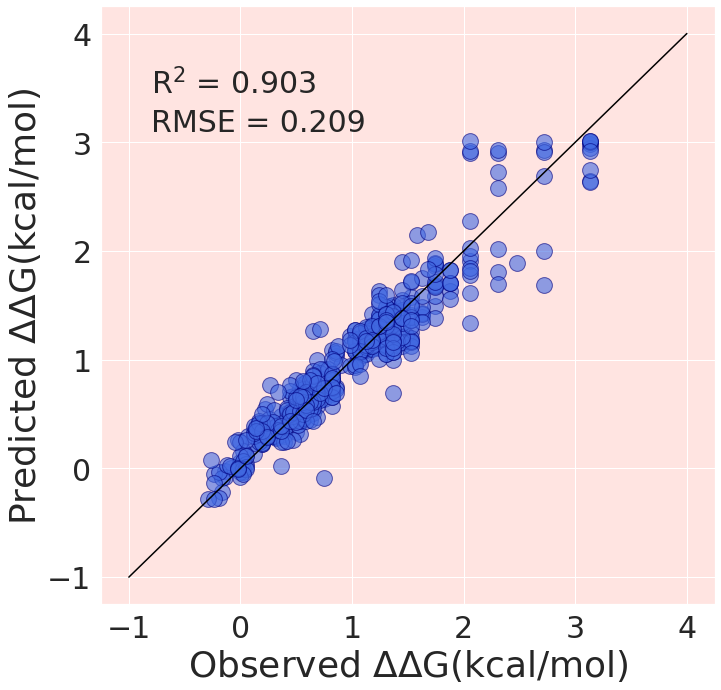

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
sns.set(style='darkgrid')
fig = plt.figure(figsize=(11,11),facecolor='white',   
           edgecolor='black')
plt.scatter(y_val,y_pred,s=250, c='royalblue', label="samples",alpha=0.6,edgecolors='navy')
plt.plot([-1,4],[-1,4],c='black')
ax=plt.gca()
ax.set_facecolor('mistyrose')#oldlace   mistyrose
plt.xlabel("Observed $\Delta$$\Delta$G(kcal/mol)",fontsize=36)
plt.ylabel("Predicted $\Delta$$\Delta$G(kcal/mol)",fontsize=36)
plt.tick_params(labelsize=30)
plt.text(-0.8,3.1,'RMSE = %.3f'%(mean_squared_error(y_val,y_pred))**(0.5),fontsize=30)
plt.text(-0.8,3.45,'R$^2$ = %.3f'%r2_score(y_val,y_pred),fontsize=30)
plt.show()
fig.savefig('./denmark_random_fig.png',dpi=400)

In [32]:
np.save('./result/data2_SEMG_MIGNN_y_val.npy',y_val)
np.save('./result/data2_SEMG_MIGNN_y_pred.npy',y_pred)